## Binary Classification with a Bank Churn Dataset
Objective of this model is to predict whether a customer continues with their account or closes it (e.g., churns).

In [2]:
# setup
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Install dataset from Kaggle

In [ ]:
# download contest data
! kaggle competitions download -c playground-series-s4e1
! unzip playground-series-s4e1.zip

Import libraries

In [9]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

First, let's import training data. Before we continue, we perform some data pre-processing. In our data, we have columns of non-numerical data. We drop irrelevant ones and one-hot encode ones that do. We perform some basic feature selection, and drop columns that may not provide meaningful insight during training.

In [10]:
data_path = './train.csv'
loaded_data = pd.read_csv(data_path)
loaded_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


Our dataset is consists of non-numeric data, so we will need to perform some encodig and feature extraction

In [11]:
# Drop irrelevant columns (id, CustomerId, Surname)
loaded_data = loaded_data.drop(columns=["id", "CustomerId", "Surname"])

# one-hot encode categorical variables
loaded_data = pd.get_dummies(loaded_data, columns=["Geography", "Gender"])

# Seperate features and labels
loaded_labels = loaded_data["Exited"]
loaded_data = loaded_data.drop(columns=["Exited"])

loaded_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,1,0,0,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,1,0,0,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,1,0,0,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,1,0,0,0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,1,0,1


Given the dataset's size, we can allocate a training set, validation set, and a test set. We'll allocate these as follows:

In [12]:
# Split the data into training+validation and test sets
temp_data, test_data, temp_labels, test_labels = train_test_split(
    loaded_data, loaded_labels, test_size=0.2, random_state=42
)

# Further split the temporary data into training (80%) and validation (20%)
train_data, validation_data, train_labels, validation_labels = train_test_split(
    temp_data, temp_labels, test_size=0.2, random_state=42
)

train_data.shape

(105621, 13)

We now have tensors with numerial data. The range of each feature varys drastically, so perform scaling. We'll use a standard scaler to standardize the dataset by scaling its features so that they have the properties of a standard normal distribution. It's important that we are doing this after we have allocated different datasets.

In [13]:
# Normalize/Standardize numerical features
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
validation_data = scaler.fit_transform(validation_data)

With data scalled, we define our model:

In [14]:
input_shape = loaded_data.shape[1:]
input_shape

def build_model():
  inputs = layers.Input(shape=input_shape)
  hidden = layers.Dense(32, activation='relu')(inputs)
  hidden = layers.Dropout(0.2)(hidden)
  hidden = layers.Dense(16, activation='relu')(hidden)
  hidden = layers.Dropout(0.2)(hidden)
  outputs = layers.Dense(1, activation='sigmoid')(hidden)

  model = keras.models.Model(inputs=inputs, outputs=outputs, name="Bank_Churn_Model")

  model.compile(optimizer=RMSprop(),
                loss=BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

model = build_model()
model.summary()

Model: "Bank_Churn_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 32)                448       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 993 (3.88 KB)
Trainable params: 993 

We've built this model with Keras' Functional API. We compile it with an `RMSprop` optimizer and `BinaryCrossentropy` loss function, as these are often used in binary classification tasks. With it defined, we begin training, passing in our validation dataset as well.

In [15]:
history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=256,
                    validation_data=(validation_data, validation_labels))

Epoch 1/10
413/413 [==============================] - 2s 3ms/step - loss: 0.4288 - accuracy: 0.8191 - val_loss: 0.3705 - val_accuracy: 0.8427
Epoch 2/10
413/413 [==============================] - 1s 2ms/step - loss: 0.3785 - accuracy: 0.8415 - val_loss: 0.3462 - val_accuracy: 0.8541
Epoch 3/10
413/413 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.8485 - val_loss: 0.3351 - val_accuracy: 0.8614
Epoch 4/10
413/413 [==============================] - 1s 2ms/step - loss: 0.3502 - accuracy: 0.8533 - val_loss: 0.3306 - val_accuracy: 0.8620
Epoch 5/10
413/413 [==============================] - 1s 3ms/step - loss: 0.3454 - accuracy: 0.8554 - val_loss: 0.3292 - val_accuracy: 0.8615
Epoch 6/10
413/413 [==============================] - 1s 3ms/step - loss: 0.3439 - accuracy: 0.8556 - val_loss: 0.3286 - val_accuracy: 0.8637
Epoch 7/10
413/413 [==============================] - 1s 2ms/step - loss: 0.3422 - accuracy: 0.8566 - val_loss: 0.3274 - val_accuracy: 0.8633
Epoch 

Finally, we can plot the model's performance

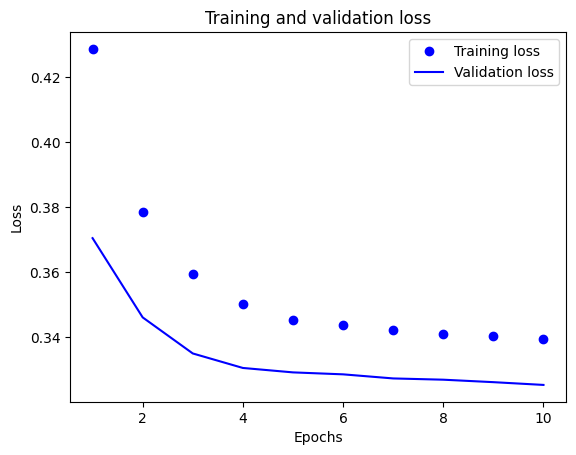

In [16]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Training further results in validation loss and training loss plateuing, stop training at 20 epochs. Next, we evaluate model performance on test-data set.

In [17]:
test_data = scaler.fit_transform(test_data)

loss_of_model, accuracy_of_model = model.evaluate(test_data, test_labels)
print(loss_of_model)
print(accuracy_of_model)

1032/1032 [==============================] - 1s 1ms/step - loss: 0.3232 - accuracy: 0.8645
0.32323968410491943
0.8645438551902771


We obtain an accuracy of `86%` and a loss value of `0.32`. Finally, let's make our predictions. We first process the data like before

In [28]:
test_data_path = './test.csv'
test_data = pd.read_csv(test_data_path)
test_id = test_data['id']

# Drop irrelevant columns (id, CustomerId, Surname)
test_data = test_data.drop(columns=["id", "CustomerId", "Surname"])

# one-hot encode categorical variables
test_data = pd.get_dummies(test_data, columns=["Geography", "Gender"])

test_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,586,23.0,2,0.00,2,0.0,1.0,160976.75,1,0,0,1,0
1,683,46.0,2,0.00,1,1.0,0.0,72549.27,1,0,0,1,0
2,656,34.0,7,0.00,2,1.0,0.0,138882.09,1,0,0,1,0
3,681,36.0,8,0.00,1,1.0,0.0,113931.57,1,0,0,0,1
4,752,38.0,10,121263.62,1,1.0,0.0,139431.00,0,1,0,0,1


In [30]:
prediction = model.predict(test_data)
prediction = np.reshape(prediction, [prediction.shape[0]])
prediction.shape, test_id.shape

3439/3439 [==============================] - 5s 1ms/step


((110023,), (110023,))

In [31]:
df = pd.DataFrame(data = {"id": test_id, "Exited": prediction})
df.head()

,id,Exited
0,165034,1.0
1,165035,1.0
2,165036,1.0
3,165037,1.0
4,165038,0.0


In [32]:
df.to_csv('submission.csv')